In [3]:
#pip install torchsampler

<hr>

<hr>

In [2]:
%config InlineBackend.figure_format = 'retina' # For high-resolution.
import pandas as pd
import numpy as np
import pydicom as dicom
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import os

import torch 
from torch import Tensor
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms, models
from torch.optim import Adam


import cv2
from tqdm.notebook import tqdm


import warnings
warnings.filterwarnings('ignore')

import segmentation_models_pytorch as smp
from torchsampler import ImbalancedDatasetSampler


from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from scipy.stats import pearsonr
from sklearn.metrics import confusion_matrix

In [3]:
## Hyperparameters
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)
print(torch.cuda.device_count())

RESOLUTION = 256
BATCH_SIZE = 4
NUM_WORKERS = 4
PIN_MEMORY = True
DROP_LAST = True

LEARNING_RATE = 1e-4
NUM_EPOCHS = 3

THRESHOLD = 0.3
# MIN_ACTIVATION_SIZE = 


cuda
1


In [4]:
def read_df(df_type):
    username = os.getcwd().split('/')[2]
    df_path = '/home/{}/teams/dsc-180a---a14-[88137]/CANDID_PTX_csv/{}.csv'.format(username, df_type)
    df = pd.read_csv(df_path)[['Mask_Path', 'XRay_Path']]
    df['Mask_Path'] = df['Mask_Path'].str.replace('anw008', username)
    df['XRay_Path'] = df['XRay_Path'].str.replace('anw008', username)
    df['No_Pneumothorax'] = df['Mask_Path'].str.contains('negative_mask').astype(int)
    df['Yes_Pneumothorax'] = 1 - df['No_Pneumothorax']
    
    
    return df

In [5]:
train_df = read_df('train')
val_df = read_df('validation')
test_df = read_df('test')

In [94]:
mask_path = val_df.iloc[4, 0]
mask_one = plt.imread(mask_path)[:, :, 0]
np.unique(mask_one)

array([0., 1.], dtype=float32)

[0.   0.25 0.5  0.75 1.  ]


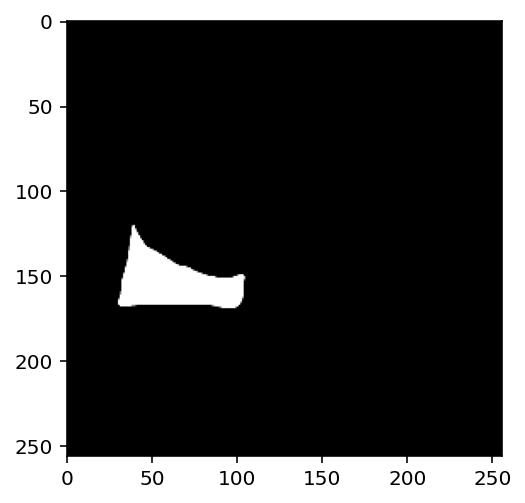

In [95]:
resize_mask = cv2.resize(mask_one, (256, 256))
print(np.unique(resize_mask))
plt.imshow(resize_mask, cmap='gray')

In [96]:
np.unique(np.where(resize_mask < 0.5, 0, 1))

array([0, 1])

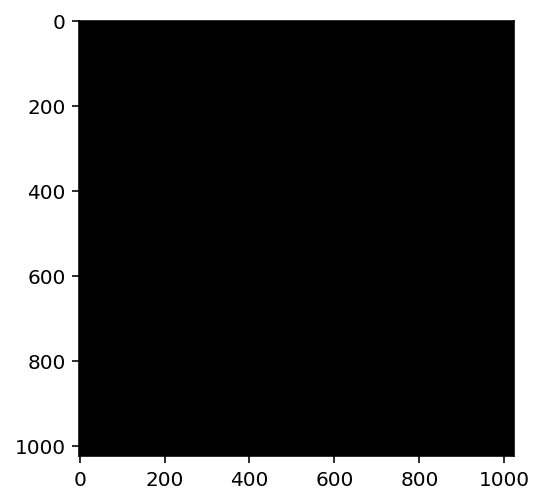

In [92]:
plt.imshow(mask_one, cmap='gray')

In [97]:
class CANDID_PTX(Dataset):
    def __init__(self, df, resolution, model_type):
        self.img_paths = df['XRay_Path'].values
        self.mask_paths = df['Mask_Path'].values
        self.labels = torch.tensor(df[['Yes_Pneumothorax', 'No_Pneumothorax']].values, dtype=torch.float32)
    
        self.resolution = resolution
        
        # model_type: 'C' for Classification, 'S' for Segmentation
        self.model_type = model_type
              
        return
            
    
    def __len__(self):
        
        return self.img_paths.shape[0]
    
    
    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = dicom.dcmread(img_path).pixel_array
        img_min = np.min(img)
        img_max = np.max(img)
        img_norm = (img - img_min) / (img_max - img_min)
        img_norm = cv2.resize(img_norm, (self.resolution, self.resolution))
        img_norm = torch.tensor(img_norm).expand(3, self.resolution, self.resolution)
        
        if self.model_type == 'C':
            label = self.labels[idx]
            
            return img_norm, label
        
        elif self.model_type == 'S':
            mask_path = self.mask_paths[idx]
            mask = plt.imread(mask_path)[:, :, 0]
            mask = cv2.resize(mask, (self.resolution, self.resolution))
            mask = np.where(mask < 0.5, 0, 1)
            mask = torch.tensor(mask).expand(1, self.resolution, self.resolution) 

            return img_norm, mask

In [7]:
def create_loaders(model_type):
    train_ds = CANDID_PTX(train_df, RESOLUTION, model_type)
    val_ds = CANDID_PTX(val_df, RESOLUTION, model_type)
    test_ds = CANDID_PTX(test_df, RESOLUTION, model_type)
    
    train_loader = DataLoader(train_ds, batch_size = BATCH_SIZE, num_workers = NUM_WORKERS, 
                          pin_memory = PIN_MEMORY, drop_last = DROP_LAST, shuffle = True)

    val_loader = DataLoader(val_ds, batch_size = BATCH_SIZE, num_workers = NUM_WORKERS, 
                              pin_memory = PIN_MEMORY, drop_last = DROP_LAST, shuffle = False)

    test_loader = DataLoader(test_ds, batch_size = BATCH_SIZE, num_workers = NUM_WORKERS, 
                              pin_memory = PIN_MEMORY, drop_last = DROP_LAST, shuffle = False)
    
    
    return train_loader, val_loader, test_loader

In [8]:
# ### Create Dataset
# train_ds = CANDID_PTX(train_df, RESOLUTION, 'C')
# # new_train_ds = CANDID_PTX(new_train_df, RESOLUTION, 'C')
# val_ds = CANDID_PTX(val_df, RESOLUTION, 'C')
# test_ds = CANDID_PTX(test_df, RESOLUTION, 'C')

# ### Create Dataloader
# train_loader = DataLoader(train_ds, batch_size = BATCH_SIZE, num_workers = NUM_WORKERS, 
#                           pin_memory = PIN_MEMORY, drop_last = DROP_LAST, shuffle = True)

# val_loader = DataLoader(val_ds, batch_size = BATCH_SIZE, num_workers = NUM_WORKERS, 
#                           pin_memory = PIN_MEMORY, drop_last = DROP_LAST, shuffle = False)

# test_loader = DataLoader(test_ds, batch_size = BATCH_SIZE, num_workers = NUM_WORKERS, 
#                           pin_memory = PIN_MEMORY, drop_last = DROP_LAST, shuffle = False)


# # new_train_loader = DataLoader(
# #     new_train_ds,
# #     sampler=ImbalancedDatasetSampler(new_train_ds),
# #     batch_size = BATCH_SIZE, num_workers = NUM_WORKERS, 
# #     pin_memory = PIN_MEMORY, drop_last = DROP_LAST, shuffle = Trues
# # )

In [9]:
loaders_seg = create_loaders('S')


In [83]:
test_df[test_df['Yes_Pneumothorax'] == 1].lo

Mask_Path  \
5     /home/mel011/teams/dsc-180a---a14-[88137]/CAND...   
26    /home/mel011/teams/dsc-180a---a14-[88137]/CAND...   
28    /home/mel011/teams/dsc-180a---a14-[88137]/CAND...   
43    /home/mel011/teams/dsc-180a---a14-[88137]/CAND...   
50    /home/mel011/teams/dsc-180a---a14-[88137]/CAND...   
...                                                 ...   
1899  /home/mel011/teams/dsc-180a---a14-[88137]/CAND...   
1901  /home/mel011/teams/dsc-180a---a14-[88137]/CAND...   
1909  /home/mel011/teams/dsc-180a---a14-[88137]/CAND...   
1911  /home/mel011/teams/dsc-180a---a14-[88137]/CAND...   
1919  /home/mel011/teams/dsc-180a---a14-[88137]/CAND...   

                                              XRay_Path  No_Pneumothorax  \
5     /home/mel011/teams/dsc-180a---a14-[88137]/CAND...                0   
26    /home/mel011/teams/dsc-180a---a14-[88137]/CAND...                0   
28    /home/mel011/teams/dsc-180a---a14-[88137]/CAND...                0   
43    /home/mel011/teams/dsc-180a---a14-[88137]/CAND...                0   
50    /home/mel011/teams/dsc-180a---a14-[88137]/CAND...                0   
...                                                 ...              ...   
1899  /home/mel011/teams/dsc-180a---a14-[88137]/CAND...                0   
1901  /home/mel011/teams/dsc-180a---a14-[88137]/CAND...                0   
1909  /home/mel011/teams/dsc-180a---a14-[88137]/CAND...                0   
1911  /home/mel011/teams/dsc-180a---a14-[88137]/CAND...                0   
1919  /home/mel011/teams/dsc-180a---a14-[88137]/CAND...                0   

      Yes_Pneumothorax  
5                    1  
26                   1  
28                   1  
43                   1  
50                   1  
...                ...  
1899                 1  
1901                 1  
1909                 1  
1911                 1  
1919                 1  

[320 rows x 4 columns]

In [62]:
loaders_seg[1]

In [79]:
(sample_1[1][0] != sample_2[1][0])[0].sum()

tensor(1841)

In [81]:
sample_2[1][0].unique()

tensor([0.0000, 0.2500, 0.5000, 0.7500, 1.0000])

In [64]:
### Test dataloader
sample_iter = iter(loaders_seg[1])
sample_1 = next(sample_iter)
sample_2 = next(sample_iter)
print("--Check length of first batch, should be 2")
print(len(sample))
print("--Check size of input images of first batch, should be ([{}, {}, {}, {}])".format(BATCH_SIZE, 3, RESOLUTION, RESOLUTION))
print(sample[0].size())
print(sample[0][0])
print("--Check size of labels/masks of first batch")
print(sample[1].size())
print(sample[1][0])

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


--Check length of first batch, should be 2
2
--Check size of input images of first batch, should be ([4, 3, 256, 256])
torch.Size([4, 3, 256, 256])
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], dtype=torch.float64)
--Check size of labels/masks of first batch
t

<hr>

In [11]:
model_seg = smp.Unet("resnet34", encoder_weights="imagenet", in_channels = 3, classes=1, activation=None)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /tmp/xdg-cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [12]:
### Modifying model
class resnet34(nn.Module):

    """

    Best to use pre-trained

    """

    def __init__(self):

        super().__init__()

        self.model = models.resnet34(pretrained=True)

        # initialize new output layer

#         layers = np.array([layer for layer in self.model.children()])

#         for layer in layers[:-4]:

#             for param in layer.parameters():
                
#                 # Change parameters for all layers
#                 param.requires_grad = False
        
#         for layer in layers[-4][:-4]:
#             for param in layer.parameters():
#                 param.requires_grad = False
        
        layers = np.array([layer for layer in self.model.children()])
        
        for layer in layers[:-2]:

            for param in layer.parameters():
                
                # Change parameters for all layers
                param.requires_grad = False
                
        self.model.fc = nn.Linear(512, 2)
        
        #num_open_param = 0
        
#         for layer in layers[-3:]:
#             for param in layer.parameters():
#                 num_open_param += 1
#         print('Num Open Parameters: ', num_open_param)


    def forward(self, x):

        x = self.model(x)

        return x

<hr>

In [58]:
def training_seg(model, num_epochs, batch_size, learning_rate, 
                    train_loader, val_loader):
    
    model.to(DEVICE)
    
    all_train_loss = []
    all_val_loss = []
    all_preds = []
    all_masks = []
    all_xray = []
    
    optimizer = Adam(model.parameters(), lr=learning_rate)
    loss_fn = torch.nn.BCEWithLogitsLoss()
    scaler = torch.cuda.amp.GradScaler()
    
    for epoch in tqdm(range(num_epochs)):
        total_train_loss = 0
        batch_num = 0
        model.train()
        
        for i, (imgs, masks) in enumerate(train_loader):
            batch_num += 1
            
            imgs, masks = imgs.to(DEVICE, dtype=torch.float), masks.to(DEVICE, dtype=torch.float)
            
            optimizer.zero_grad()
            preds = model(imgs)
            
            
            if (i == 0) & (epoch == 0):
                print(preds)
#             print(preds.size())
#             print(masks.size())

            
            loss = loss_fn(preds, masks)
    
            loss.backward()
            optimizer.step()
            
            
#             with torch.cuda.amp.autocast():
#                 preds = model(imgs)
#                 if i == 0:
#                     all_preds.append(preds.detach().cpu())
#                 loss = loss_fn(preds, masks)
                        
#             optimizer.zero_grad()
#             scaler.scale(loss).backward()
#             scaler.step(optimizer)
#             scaler.update()
            
            total_train_loss += float(loss)
            
            
        if epoch == 0:
            print("Total # of training batch: ", i + 1)

        all_train_loss.append(total_train_loss / batch_num)
            
            
    ## validation set
        batch_num = 0
        total_val_loss = 0
        model.eval()
        
        for i, (imgs, masks) in enumerate(val_loader):
            batch_num += 1
            
            imgs, masks = imgs.to(DEVICE, dtype=torch.float), masks.to(DEVICE, dtype=torch.float)
            if i == 1:
                print(masks[0].unique())
            
            preds = model(imgs)
            
            loss = loss_fn(preds, masks) # is this mean or sum?

            total_val_loss += float(loss) # accumulate the total loss for this epoch.
            
            if i == 1:
                all_preds.append(preds.detach().cpu())
                all_masks.append(masks.detach().cpu())
                all_xray.append(imgs.detach().cpu())
            
        if epoch == 0:
            print("Total # of validation batch: ", i + 1)

        all_val_loss.append(total_val_loss / batch_num)
        
    
    #plot_both_loss(all_train_loss, all_val_loss)
        
    return model, all_train_loss, all_val_loss, all_preds, all_masks, all_xray

In [107]:
unet_model, train_loss, val_loss, logit_mask, true_mask, ori_xray = training_seg(model = model_seg,
                                            num_epochs = 3, batch_size = BATCH_SIZE,
                                            learning_rate = LEARNING_RATE,
                                            train_loader = loaders_seg[0], val_loader = loaders_seg[1])

  0%|          | 0/3 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


tensor([[[[ -5.4236,  -7.8195,  -8.2421,  ...,  -6.7640,  -7.2379,  -4.9492],
          [ -7.2715, -10.5941, -11.1527,  ...,  -9.7312, -10.4108,  -7.4916],
          [ -7.8456, -11.0998, -11.3211,  ..., -11.0237, -11.7149,  -8.1475],
          ...,
          [ -7.0514, -10.2936, -10.6528,  ...,  -9.4951, -10.6973,  -7.4895],
          [ -6.9525, -10.6434, -10.8489,  ..., -10.7718, -10.9951,  -7.4194],
          [ -4.5067,  -6.5570,  -6.6878,  ...,  -6.8957,  -6.2710,  -4.3153]]],


        [[[ -5.1279,  -7.4185,  -7.7659,  ...,  -6.7344,  -6.9549,  -4.7363],
          [ -6.8333, -10.0039, -10.4399,  ...,  -9.3664,  -9.8552,  -7.0956],
          [ -7.5028, -10.5472, -10.6955,  ..., -10.6910, -11.1949,  -7.5696],
          ...,
          [ -6.8970, -10.1352, -10.6569,  ..., -10.1845, -11.3059,  -7.7013],
          [ -6.9135, -10.4848, -10.9705,  ..., -11.2104, -11.3408,  -7.5938],
          [ -4.3553,  -6.3630,  -6.5942,  ...,  -6.9736,  -6.4798,  -4.3716]]],


        [[[ -5.3322,  -7.6

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


tensor([0.0000, 0.2500, 0.5000, 0.7500, 1.0000], device='cuda:0')
Total # of validation batch:  480


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


tensor([0.0000, 0.2500, 0.5000, 0.7500, 1.0000], device='cuda:0')


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


tensor([0.0000, 0.2500, 0.5000, 0.7500, 1.0000], device='cuda:0')


In [20]:
len(logit_mask[0])

1

In [33]:
logit_mask[0][0][0]#.shape

tensor([[-2.2192, -3.0278, -2.8606,  ..., -2.1828, -2.5819, -1.5581],
        [-2.7805, -4.1317, -3.9864,  ..., -3.1070, -3.7405, -2.7540],
        [-3.3740, -4.5302, -4.1722,  ..., -3.8578, -4.3822, -2.6994],
        ...,
        [-2.8635, -4.0008, -3.5540,  ..., -3.1482, -3.8921, -2.5905],
        [-2.9892, -4.3781, -4.2172,  ..., -4.0760, -3.9785, -2.9327],
        [-1.5707, -2.1090, -2.2108,  ..., -2.2616, -1.9111, -1.3896]])

In [34]:
ori_xray[0][0][0]#.shape

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [51]:
torch.sum(true_mask[0][0][0] == true_mask[1][0][0])

tensor(65536)

In [45]:
true_mask[0][0][0].unique()#.shape

tensor([0.0000, 0.2500, 0.5000, 0.7500, 1.0000])

In [99]:
def calculate_dc(preds, true_mask):
    """
    Helper function to calculate dice coefficient from predicted and true masks, both in binary.
    """
    if np.sum(true_mask) == 0:
        # Return 0 if prediction is positive but true mask is negative
        if np.sum(preds) != 0:
            return 0
        else:
            # Return 1 if prediction and true mask are both negative
            return 1
    else:
        # Return 0 if prediction is negative but true mask is positive
        if np.sum(preds) == 0:
            return 0
        # Actually calculate dc if both prediction and mask are both positive
        dc = np.sum(preds[true_mask==1])*2.0 / (np.sum(preds) + np.sum(true_mask))
        return dc

In [100]:
def dice_coef_per_image(test_loader, model, sigmoid_threshold):
    """
    Calculate dice coefficient from a test set. Based on the average of each dice coefficient.
    Return a list 
    """
    dc_list = []
    total_num_batch = 0
    for i, (imgs, masks) in enumerate(test_loader):
        total_num_batch += 1
        imgs, masks = imgs.to(DEVICE, dtype=torch.float), masks.to(DEVICE, dtype=torch.float)
        preds = model(imgs)
        for j in range(BATCH_SIZE):
            pred = preds[j].detach().cpu().squeeze()
            pred_bi = bi_mask(pred, sigmoid_threshold)
            cur_dc = calculate_dc(pred_bi, masks[j].detach().cpu().squeeze().numpy())
            dc_list.append(cur_dc)
    print('Total Number of Batch Size: ', total_num_batch)
    return dc_list, np.mean(dc_list)

In [103]:
def bi_mask(logit_mask, threshold):
    mask = np.where(logit_mask <= threshold, 0, 1)
    
    return mask

In [109]:
dc_list, avg = dice_coef_per_image(loaders_seg[2], unet_model, 0.3)
print(avg)

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Total Number of Batch Size:  480
0.8189403376168393


dice_avg_1 = 0.8723006845597181
dice_avg_2 = 0.8662950791858317


In [ ]:
class CANDID_PTX(Dataset):
    def __init__(self, df, resolution, model_type):
        self.img_paths = df['XRay_Path'].values
        self.mask_paths = df['Mask_Path'].values
        self.labels = torch.tensor(df[['Yes_Pneumothorax', 'No_Pneumothorax']].values, dtype=torch.float32)
    
        self.resolution = resolution
        
        # model_type: 'C' for Classification, 'S' for Segmentation
        self.model_type = model_type
                  
        return
            
    
    def __len__(self):
        
        return self.img_paths.shape[0]
    
    
    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = dicom.dcmread(img_path).pixel_array
        img_min = np.min(img)
        img_max = np.max(img)
        img_norm = (img - img_min) / (img_max - img_min)
        img_norm = cv2.resize(img_norm, (self.resolution, self.resolution))
        img_norm = torch.tensor(img_norm).expand(3, self.resolution, self.resolution)
        
        if self.model_type == 'C':
            label = self.labels[idx]
            
            return img_norm, label
        
        elif self.model_type == 'S':
            mask_path = self.mask_paths[idx]
            mask = plt.imread(mask_path)[:, :, 0]
            mask = cv2.resize(mask, (self.resolution, self.resolution))
            mask = torch.tensor(mask).expand(1, self.resolution, self.resolution) 

            return img_norm, mask

In [ ]:
def training_class(model, num_epochs, batch_size, learning_rate, 
                    train_loader, val_loader):
    
    model.to(DEVICE)
    
    all_train_loss = []
    all_val_loss = []
#     all_preds = []
#     all_masks = []
#     all_xray = []
    
    optimizer = Adam(model.parameters(), lr=learning_rate)
    loss_fn = torch.nn.BCEWithLogitsLoss()
    scaler = torch.cuda.amp.GradScaler()
    
    for epoch in tqdm(range(num_epochs)):
        total_train_loss = 0
        batch_num = 0
        model.train()
        
        for i, (imgs, labels) in enumerate(train_loader):
            batch_num += 1
            
            imgs, labels = imgs.to(DEVICE, dtype=torch.float), labels.to(DEVICE, dtype=torch.float)
            
            optimizer.zero_grad()
            preds = model(imgs)
            
            
            if (i == 0) & (epoch == 0):
                print(preds)
                print(labels)
#             print(preds.size())
#             print(masks.size())

            
            loss = loss_fn(preds, labels)
    
            loss.backward()
            optimizer.step()
            
            
#             with torch.cuda.amp.autocast():
#                 preds = model(imgs)
#                 if i == 0:
#                     all_preds.append(preds.detach().cpu())
#                 loss = loss_fn(preds, masks)
                        
#             optimizer.zero_grad()
#             scaler.scale(loss).backward()
#             scaler.step(optimizer)
#             scaler.update()
            
            total_train_loss += float(loss)
            
            
        if epoch == 0:
            print("Total # of training batch: ", i + 1)

        all_train_loss.append(total_train_loss / batch_num)
            
            
    ## validation set
        batch_num = 0
        total_val_loss = 0
        model.eval()
        
        for i, (imgs, labels) in enumerate(val_loader):
            batch_num += 1
            
            imgs, labels = imgs.to(DEVICE, dtype=torch.float), labels.to(DEVICE, dtype=torch.float)
            
            preds = model(imgs)
            
            loss = loss_fn(preds, labels) # is this mean or sum?

            total_val_loss += float(loss) # accumulate the total loss for this epoch.
            
#             if i == 1:
#                 all_preds.append(preds.detach().cpu())
#                 all_masks.append(masks.detach().cpu())
#                 all_xray.append(imgs.detach().cpu())
            
        if epoch == 0:
            print("Total # of validation batch: ", i + 1)

        all_val_loss.append(total_val_loss / batch_num)
        
    
    #plot_both_loss(all_train_loss, all_val_loss)
        
    return model, all_train_loss, all_val_loss#, all_preds, all_masks, all_xray

In [ ]:
model_class = resnet34()

In [30]:
resnet_model, train_loss, val_loss = training(model = model_class,
                                            num_epochs = NUM_EPOCHS, batch_size = BATCH_SIZE,
                                            learning_rate = LEARNING_RATE,
                                            train_loader = loaders_class[0], val_loader = loaders_class[1])

NameError: name 'training' is not defined

In [ ]:
def plot_both_loss(all_train_loss, all_val_loss, model_name, resolution):
    plt.figure(figsize=(20, 10))
    sns.set(style="whitegrid")
    epoch_num = len(all_train_loss)
    df = pd.DataFrame({'x':range(epoch_num),
                    'train_loss':all_train_loss,
                      'val_loss':all_val_loss})
    df = df.set_index('x')
    
    train_val_loss = sns.lineplot(data=df, linewidth=2.5)

    ## now label the y- and x-axes.
    plt.ylabel('BCE Loss')
    plt.xlabel('Epoch Number')
    plt.title('BCE Loss of {} with resolution {}'.format(model_name, resolution))
    plt.show()
    
    fig = train_val_loss.get_figure()
    #fig.save('train_val_loss.png')

In [ ]:
plot_both_loss(train_loss, val_loss, 'resnet34+unet', str(RESOLUTION))